In [2]:
import os
logs = "OPTUNA_OUTPUT_LOG"
num_trials = 20
stored_logs = {}

for folder in sorted(os.listdir(logs)):
    print(folder)
    folder_path = os.path.join(logs, folder)
    for file in os.listdir(folder_path):
        with open(os.path.join(folder_path, file), "r") as f:
            lines = f.readlines()
            # first few lines contain information on language used etc.
            lines = lines[2:num_trials + 2]
            if len(lines) != 20:
                print(f"ERROR: {folder} {file}")
            else:
                lines = ["failed" if "failed with" in line else line for line in lines]
                stored_logs[folder] = lines
        break

amh
arq
ary
eng
esp
hau
kin
mar
tel


In [27]:
import re

studies = {}
for lang, data in stored_logs.items():
    study = {}  # trial -> data
    for trial in data:
        if "failed" == trial:
            continue
        # Trial 0 finished with value: 0.5275255934639471 and parameters: {'learning_rate': 1.1683502245681621e-06, 'k': 1, 'weak_training': 0, 'max_grad_norm': 0.6884684333211815}. Best is trial 0 with value: 0.5275255934639471.
        trial_val = re.search(r"value: (.+?) and", trial).group(1)
        trial_val = float(trial_val)
        # extract hyperparams:
        hparams = re.search(r"parameters: (.+?)\. ", trial).group(1)
        hparams = eval(hparams)
        study[trial_val] = hparams
    study = dict(sorted(study.items(), key=lambda item: item[0], reverse=False))
    studies[lang] = study

In [29]:
best_params = {}
for lang, data in studies.items():
    for val, hparams in data.items():
        best_params[lang] = hparams
        best_params[lang]["score"] = val
best_params

{'amh': {'learning_rate': 8.422592463674403e-05,
  'k': 3,
  'epochs': 5,
  'weak_training': 2,
  'max_grad_norm': 0.7993216901753878,
  'score': 0.8572310399719895},
 'arq': {'learning_rate': 9.803817902129585e-05,
  'k': 1,
  'epochs': 4,
  'weak_training': 2,
  'max_grad_norm': 0.8200407012149172,
  'score': 0.4857519303246593},
 'ary': {'learning_rate': 9.008221697385652e-05,
  'k': 1,
  'epochs': 4,
  'weak_training': 2,
  'max_grad_norm': 0.9907041482577404,
  'score': 0.8168188267618992},
 'eng': {'learning_rate': 3.33906502533679e-05,
  'k': 2,
  'epochs': 2,
  'weak_training': 2,
  'max_grad_norm': 0.11716253713299332,
  'score': 0.8394945901785925},
 'esp': {'learning_rate': 2.400716984952928e-05,
  'k': 1,
  'epochs': 5,
  'weak_training': 2,
  'max_grad_norm': 0.8481962179447173,
  'score': 0.7251570765767283},
 'hau': {'learning_rate': 4.8696183456274e-05,
  'k': 0,
  'epochs': 3,
  'weak_training': 2,
  'max_grad_norm': 0.6479826472270562,
  'score': 0.706809691888171},
 

In [51]:
import pandas as pd
best_params = {}
for lang, data in studies.items():
    for val, hparams in data.items():
        best_params[lang] = hparams
        best_params[lang]["score"] = val
best_params
df = pd.DataFrame(best_params).T
df["score"] = df["score"].apply(lambda x: f"{x*100:.2f}")
df["max_grad_norm"] = df["max_grad_norm"].apply(lambda x: f"{float(x):.2f}")
df["learning_rate"] = df["learning_rate"].apply(lambda x: f"{float(x):.2e}")

df.rename(columns={"weak_training": r"$\mathcal{E}_{weak}$"}, inplace=True)
df.rename(columns={"learning_rate": "lr"}, inplace=True)
df.rename(columns={"k": r"$k$"}, inplace=True)
df.rename(columns={"max_grad_norm": "maxgrad"}, inplace=True)
print(df.to_latex())
df

,learning_rate,k,epochs,weak_training,max_grad_norm,score
amh,0.000084,3.0,5.0,2.0,0.799322,0.857231
arq,0.000098,1.0,4.0,2.0,0.820041,0.485752
ary,0.000090,1.0,4.0,2.0,0.990704,0.816819
eng,0.000033,2.0,2.0,2.0,0.117163,0.839495
esp,0.000024,1.0,5.0,2.0,0.848196,0.725157
hau,0.000049,0.0,3.0,2.0,0.647983,0.706810
kin,0.000025,0.0,5.0,1.0,0.668878,0.739157
mar,0.000053,3.0,2.0,2.0,0.415300,0.888051
tel,0.000037,3.0,3.0,1.0,0.655917,0.868162


amh


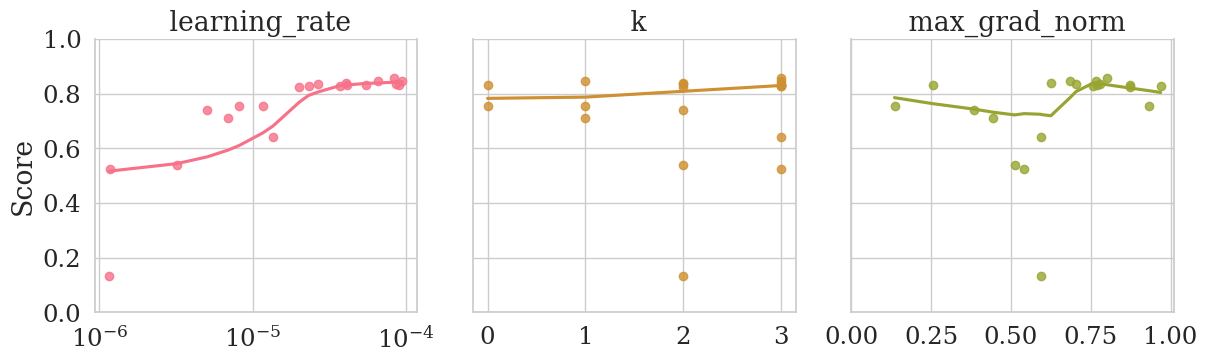

arq


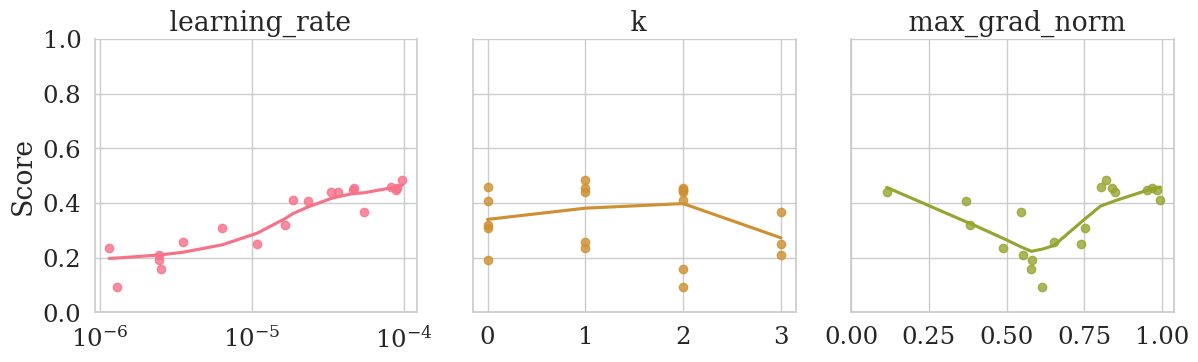

ary


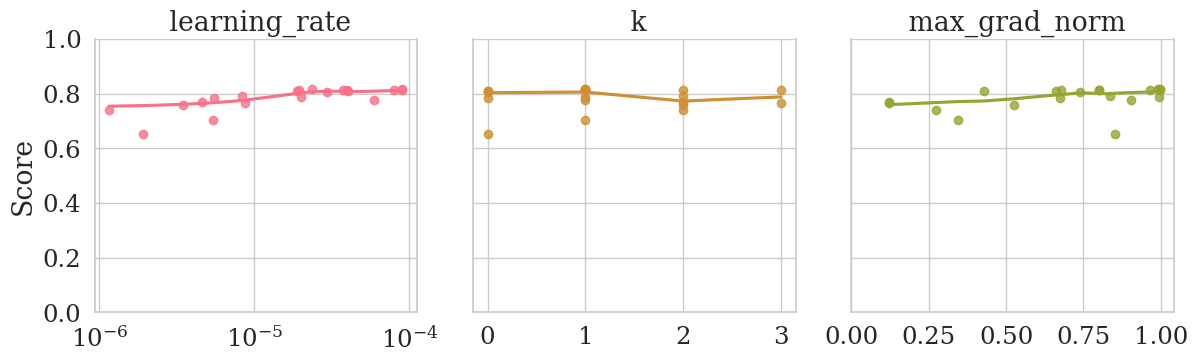

eng


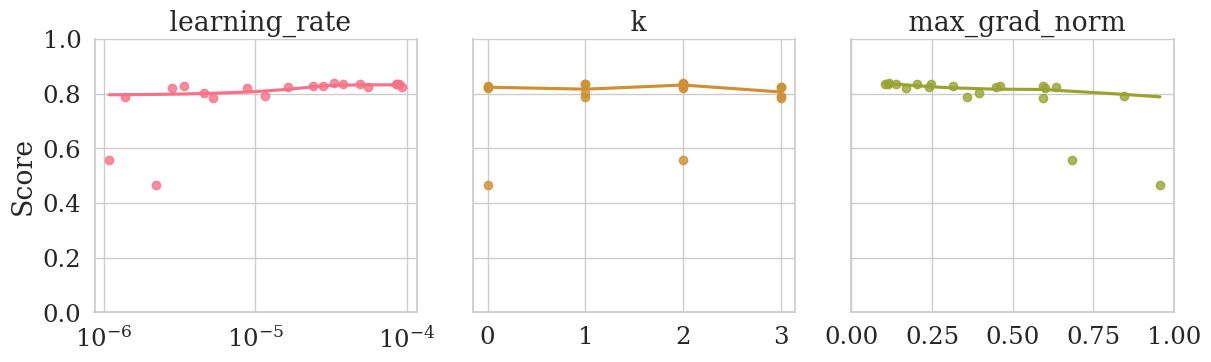

esp


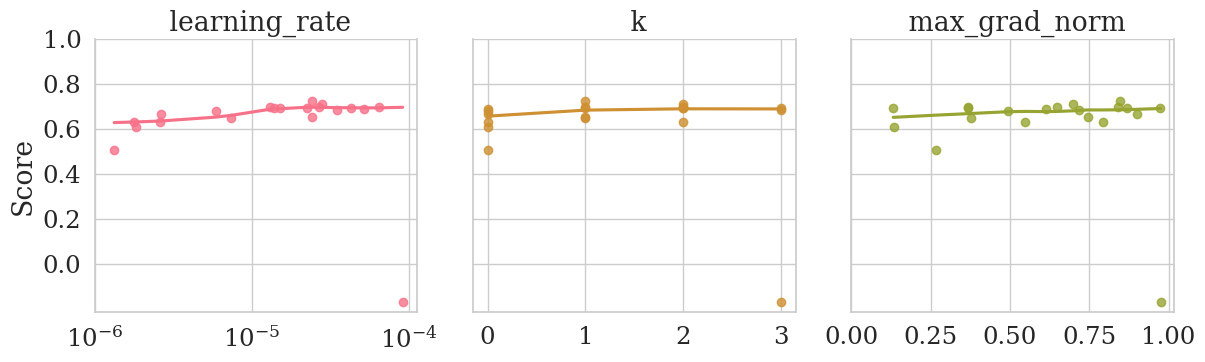

hau


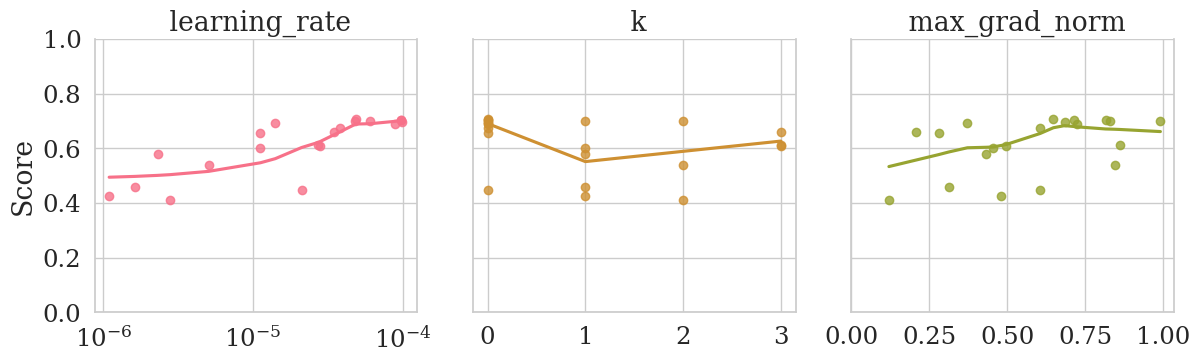

kin


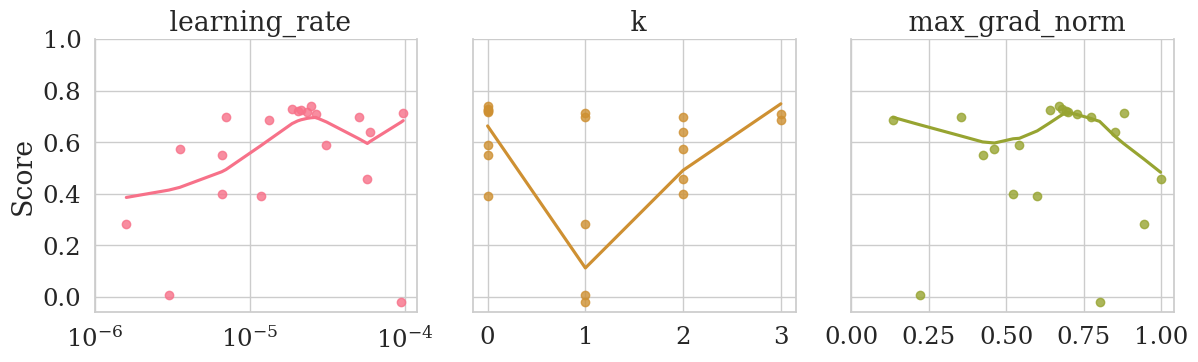

mar


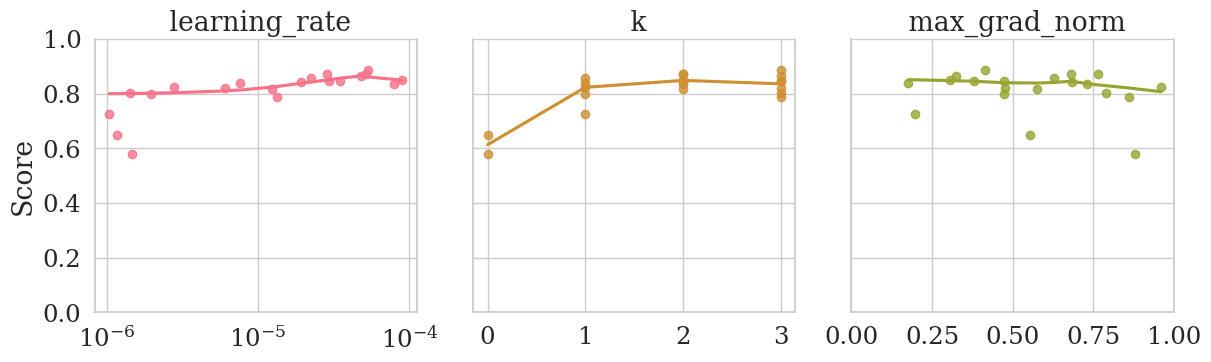

tel


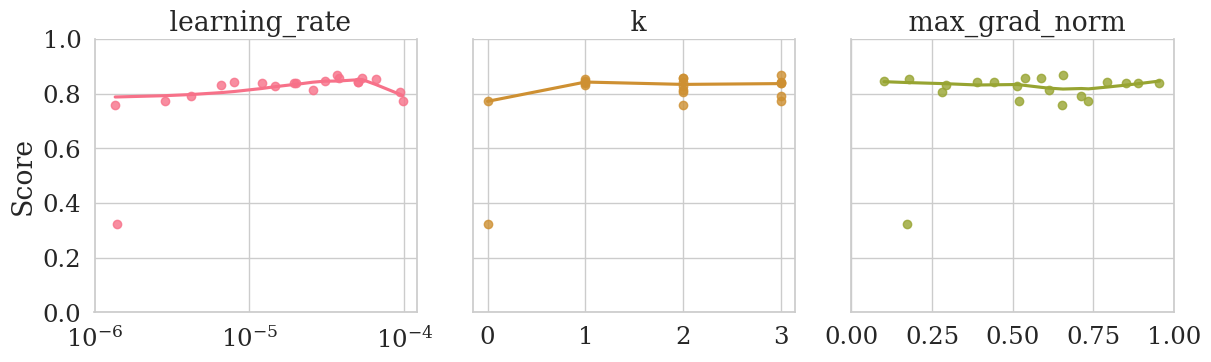

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid", font_scale=1.6, font='Serif')
colors = sns.color_palette("husl", 8)

def plot_study(study, lang):
    scores = list(study.keys())
    hyperparams = [study[score] for score in scores]
    param_names = hyperparams[0].keys()
    # use only learning_rate, k, max_grad_norm
    selected_params = "learning_rate k max_grad_norm".split()
    param_names = [p for p in param_names if p in selected_params]
    
    param_values = {param: [hp[param] for hp in hyperparams] for param in param_names}
    
    param_values['Score'] = scores

    df = pd.DataFrame(param_values)
    df_melt = df.melt(id_vars='Score', var_name='Parameter', value_name='Value')
    g = sns.FacetGrid(df_melt, col='Parameter', col_wrap=4, height=4, sharex=False)
    g.map(sns.regplot, 'Value', 'Score', lowess=True, line_kws={'color': 'red', 'ls': '--'})
    # remove the x-axis "value" label
    for i, ax in enumerate(g.axes):
        ax.set_xlabel('')

    for i, ax in enumerate(g.axes):
        ax.set_title(ax.get_title().split('=')[-1])
        ax.lines[0].set_color(colors[i])
        ax.lines[0].set_linestyle('-')
        ax.collections[0].set_color(colors[i])
    g.axes[0].set_xscale('log')
    g.axes[0].set_xticks([1e-6, 1e-5, 1e-4])
    g.axes[1].set_xticks([0, 1, 2, 3])
    g.axes[2].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])

    for ax in g.axes:
        ax.set_yticks(np.arange(0.0, 1.05, 0.2))
    
    # remove grids in the middle of the plot
    # g.despine(left=True, bottom=True)
    # show no grids 
    # g.set(xticks=[], yticks=[])

    # add spines on left and right
    g.despine(left=False, right=False, bottom=False)

    plt.tight_layout()
    # save:
    plt.savefig(f"hparams/{lang}.png")
    plt.show()
    
   
langs = "amh eng tel".split()
os.makedirs("hparams", exist_ok=True)
for lang, study in studies.items():
    print(lang)
    # if lang not in langs:
    #     continue
    plot_study(study, lang)
    # break